In [4]:
# Importing neccessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.impute import KNNImputer
from scipy.stats import mstats
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.ensemble import VotingClassifier
from sklearn.tree import DecisionTreeClassifier

In [5]:
df = pd.read_csv("WELFake_Dataset.csv")
df.head()

,Unnamed: 0,title,text,label
0,0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1
1,1,NaN,Did they post their votes for Hillary already?,1
2,2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1
3,3,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0
4,4,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1


In [6]:
#cheking the shape of dataset(rows and columns)
df.shape

(72134, 4)

In [7]:
#cheking the number of unique values in each collumns
df.nunique()

Unnamed: 0    72134
title         62347
text          62718
label             2
dtype: int64

In [8]:
#droping the "Unnamed"columns
df.drop(columns=['Unnamed: 0'],axis =1 , inplace=True)
df.columns



Index(['title', 'text', 'label'], dtype='object')

In [9]:
df_col= df.columns

In [10]:
#label is our target variable so that we are dropping it from the df_col
# thus, dropping the label and creating df_label for the 'label' column
df_col = df_col[:-1]
print(f'df col:{df_col}')

df_label = df['label'].copy()
df_label.head()

df col:Index(['title', 'text'], dtype='object')


0    1
1    1
2    1
3    0
4    1
Name: label, dtype: int64

In [11]:
#checking the value counts in the colunms
for i in df_col:
    print(f"{i}:\n{df[i].value_counts()}")

title:
Factbox: Trump fills top jobs for his administration                                                  14
Get Ready For Civil Unrest: Survey Finds That Most Americans Are Concerned About Election Violence     8
Highlights: The Trump presidency on April 13 at 9:30 P.M. EDT/0130 GMT on Friday                       8
Factbox: Contenders for senior jobs in Trump's administration                                          8
Michael Moore Owes Me $4.99                                                                            7
                                                                                                      ..
Population of Vertebrate Animals Fell 58% From 1970-2012                                               1
Italy's Renzi pledges to hike budget deficit if he wins election                                       1
Motion Picture Academy, After Diversifying, Keeps Leadership Intact - The New York Times               1
Donald Trump, Delhi, Theresa May: Your Monday Br

In [8]:
# checking the number of null values in the columns
df[df_col].isnull().sum()

title    558
text      39
label      0
dtype: int64

In [13]:
#imputing the categorical variable with their mode
df_col = df[df_col].copy()
for i in df_col:
    mode = df[i].mode()[0]
    df_col.loc[:, i].fillna(mode, inplace = True)

df_col.isnull().sum()


title    0
text     0
dtype: int64

In [14]:
# Encoding categorical columns
label = LabelEncoder()
for i in df_col:
    if df_col[i].dtype == 'object':
        df_col[i] = label.fit_transform(df_col[i])

df_col.head()

,title,text
0,32786,34016
1,23713,16056
2,56848,1431
3,14758,5257
4,44281,45159


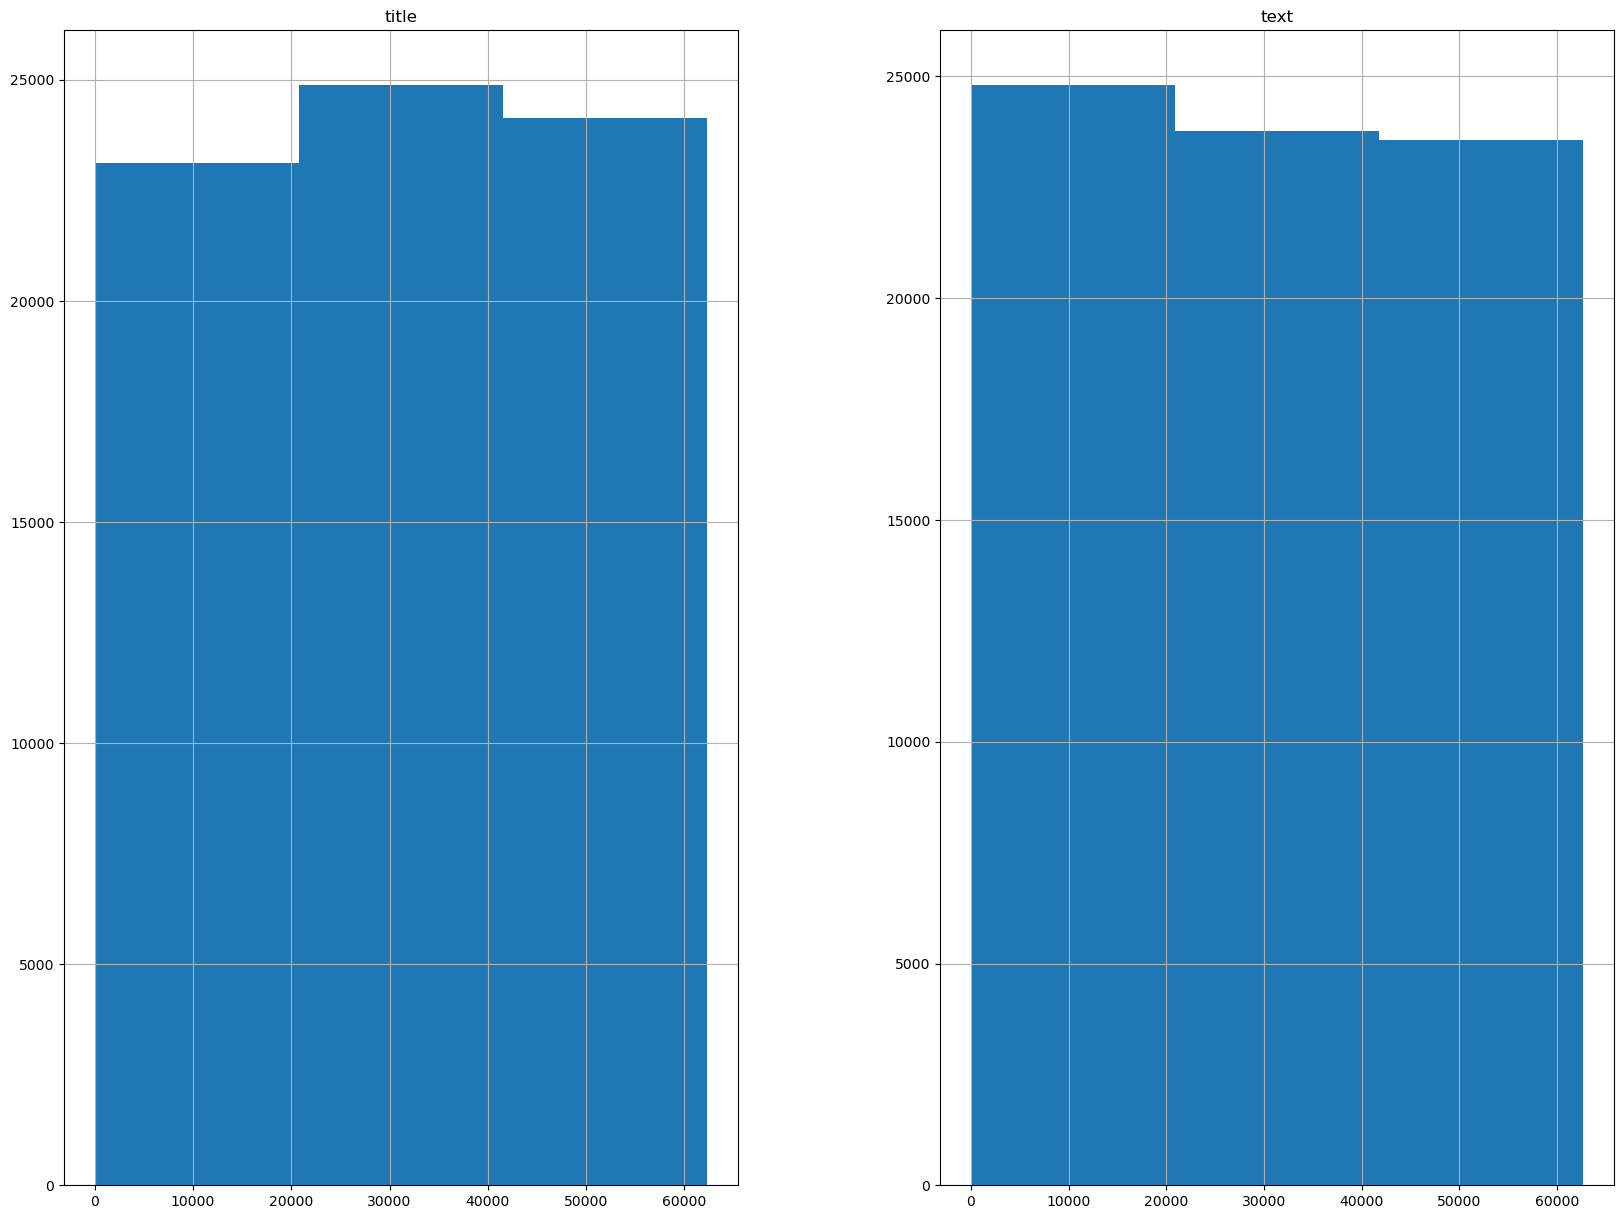

In [20]:

df_col.hist(bins=3,figsize=(20,15))
plt.show()

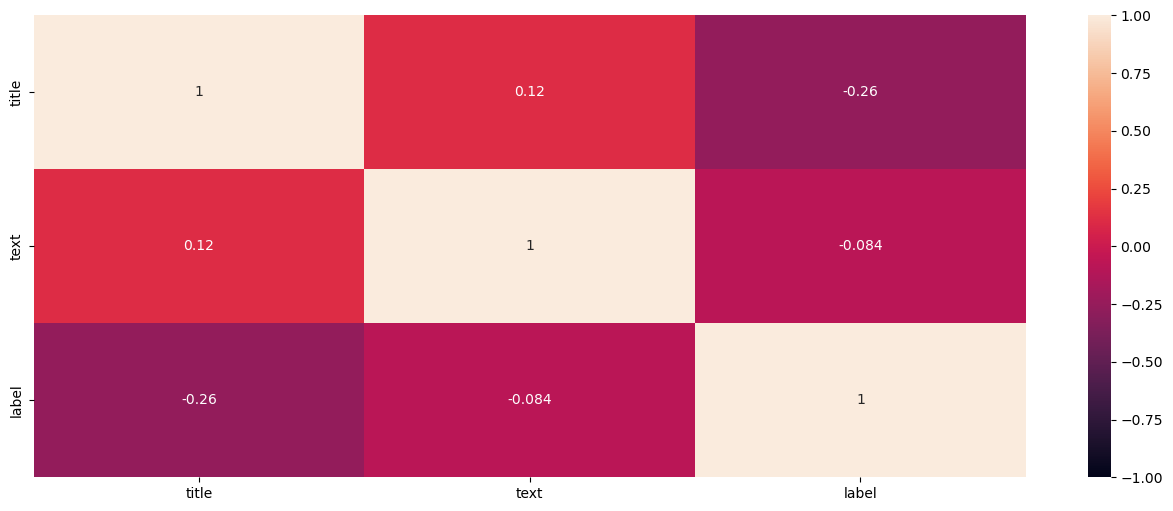

In [22]:
# Checking correlation of column  data with the target variable and with each other for multicollinearity
corr_data = pd.concat([df_col, df_label], axis=1)
plt.figure(figsize=(16, 6))
sns.heatmap(data = corr_data.corr(), vmin=-1, vmax=1, annot=True)
plt.show()

In [25]:
#merging the label("Target") coulumn and categorical column togetherafter cleaning
df_features = pd.concat([df_col, df_label], axis=1)
print(df_features.isnull().sum())
df_features.head()

title    0
text     0
label    0
dtype: int64


,title,text,label
0,32786,34016,1
1,23713,16056,1
2,56848,1431,1
3,14758,5257,0
4,44281,45159,1


Train Test Split

In [27]:
df_full = pd.concat([df_col, df_label], axis = 1)

# Splitting training and testing datasets
train_set, test_set = train_test_split(df_full, test_size=0.3, random_state=42)

y_train = train_set['label']
X_train = train_set.drop(columns=['label'])
y_test = test_set['label']
X_test = test_set.drop(columns=['label'])

In [28]:
# Checking shape of training and testing datasets
print("Shape of x_train: ", X_train.shape)
print("Shape of y_train: ", y_train.shape)
print("Shape of x_test: ", X_test.shape)
print("Shape of y_test: ", y_test.shape)

Shape of x_train:  (50493, 2)
Shape of y_train:  (50493,)
Shape of x_test:  (21641, 2)
Shape of y_test:  (21641,)


In [33]:
# Checking value_counts of target variable
df_full['label'].value_counts()

1    37106
0    35028
Name: label, dtype: int64

In [34]:
#fitting the model
lr = LogisticRegression(max_iter = 1000, random_state=42)
lr.fit(X_train_scaled, y_train)


LogisticRegression(max_iter=1000, random_state=42)

In [35]:
# Making predictions on training data
train_pred_logit = lr.predict(X_train)
print(classification_report(y_train, train_pred_logit))

              precision    recall  f1-score   support

           0       0.55      0.78      0.64     24415
           1       0.66      0.41      0.50     26078

    accuracy                           0.59     50493
   macro avg       0.61      0.59      0.57     50493
weighted avg       0.61      0.59      0.57     50493



In [36]:
# Making predictions on testing data
test_pred_logit = lr.predict(X_test)
print(classification_report(y_test, test_pred_logit))

              precision    recall  f1-score   support

           0       0.56      0.77      0.65     10613
           1       0.65      0.41      0.51     11028

    accuracy                           0.59     21641
   macro avg       0.60      0.59      0.58     21641
weighted avg       0.60      0.59      0.57     21641



In [39]:
# Creating Voting Classifier Model and fitting data
lr_clf = LogisticRegression(max_iter=1000, random_state=42)
dt_clf = DecisionTreeClassifier(max_depth= 20, min_samples_leaf=15, random_state=42)
ensemble_clf = VotingClassifier(estimators=[('lr', lr_clf), ('dt', dt_clf)], voting='soft')
ensemble_clf.fit(X_train_scaled, y_train)

VotingClassifier(estimators=[('lr',
                              LogisticRegression(max_iter=1000,
                                                 random_state=42)),
                             ('dt',
                              DecisionTreeClassifier(max_depth=20,
                                                     min_samples_leaf=15,
                                                     random_state=42))],
                 voting='soft')

In [41]:
 #Making predictions on training data
train_pred_ensemble = ensemble_clf.predict(X_train)
print(classification_report(y_train, train_pred_ensemble))

              precision    recall  f1-score   support

           0       0.89      0.88      0.88     24415
           1       0.89      0.90      0.89     26078

    accuracy                           0.89     50493
   macro avg       0.89      0.89      0.89     50493
weighted avg       0.89      0.89      0.89     50493



In [42]:
#making prediction on testing the data
test_pred_ensemble = ensemble_clf.predict(X_test_scaled)
print(classification_report(y_test, test_pred_ensemble))

              precision    recall  f1-score   support

           0       0.88      0.86      0.87     10613
           1       0.87      0.89      0.88     11028

    accuracy                           0.87     21641
   macro avg       0.87      0.87      0.87     21641
weighted avg       0.87      0.87      0.87     21641



In [44]:
# Fitting data on Random Forest Classifier Model
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [45]:
# Making predictions on training data
train_pred_rf = rf_model.predict(X_train)
print(classification_report(y_train, train_pred_rf))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     24415
           1       1.00      1.00      1.00     26078

    accuracy                           1.00     50493
   macro avg       1.00      1.00      1.00     50493
weighted avg       1.00      1.00      1.00     50493



In [46]:
# Making predictions on testing data
test_pred_rf = rf_model.predict(X_test)
print(classification_report(y_test, test_pred_rf))

              precision    recall  f1-score   support

           0       0.93      0.91      0.92     10613
           1       0.91      0.94      0.93     11028

    accuracy                           0.92     21641
   macro avg       0.92      0.92      0.92     21641
weighted avg       0.92      0.92      0.92     21641



In [47]:
# Fitting Data
rf_model_2 = RandomForestClassifier(n_estimators=300, max_depth=10, min_samples_split=5, min_samples_leaf=5, random_state=42)
rf_model_2.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, min_samples_leaf=5, min_samples_split=5,
                       n_estimators=300, random_state=42)

In [48]:
# Making predictions on training data
train_pred_rf = rf_model_2.predict(X_train)
print(classification_report(y_train, train_pred_rf))

              precision    recall  f1-score   support

           0       0.72      0.94      0.81     24415
           1       0.92      0.66      0.77     26078

    accuracy                           0.79     50493
   macro avg       0.82      0.80      0.79     50493
weighted avg       0.82      0.79      0.79     50493



In [49]:
# Making predictions on testing data
test_pred_rf = rf_model_2.predict(X_test)
print(classification_report(y_test, test_pred_rf))

              precision    recall  f1-score   support

           0       0.72      0.93      0.82     10613
           1       0.91      0.66      0.76     11028

    accuracy                           0.79     21641
   macro avg       0.82      0.80      0.79     21641
weighted avg       0.82      0.79      0.79     21641



In [50]:
# Fitting the model
logreg_pipeline = make_pipeline(
    StandardScaler(),
    LogisticRegression(solver='lbfgs', max_iter=1000, random_state=42))
logreg_pipeline.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression',
                 LogisticRegression(max_iter=1000, random_state=42))])

In [54]:
# Making predictions on training data
train_pred_logit_poly = logreg_pipeline.predict(X_train)
print(classification_report(y_train, train_pred_logit))

              precision    recall  f1-score   support

           0       0.55      0.78      0.64     24415
           1       0.66      0.41      0.50     26078

    accuracy                           0.59     50493
   macro avg       0.61      0.59      0.57     50493
weighted avg       0.61      0.59      0.57     50493



In [56]:
# Making predictions on testing data
test_pred_logit_poly = logreg_pipeline.predict(X_test)
print(classification_report(y_test, test_pred_logit))

              precision    recall  f1-score   support

           0       0.56      0.77      0.65     10613
           1       0.65      0.41      0.51     11028

    accuracy                           0.59     21641
   macro avg       0.60      0.59      0.58     21641
weighted avg       0.60      0.59      0.57     21641

